In [42]:
from datetime import datetime
from tradingene.data.load import import_data
from tradingene.algorithm_backtest.tng import TNG
import tradingene.backtest_statistics.backtest_statistics as bs
from keras.models import Sequential
from keras.layers import Dense
import keras
import numpy as np
import pandas as pd


def prepare_model():
    data = import_data(
        ticker,
        timeframe,
        start_train_date,
        end_train_date,
        calculate_input,
        lookback,
        calculate_output,
        lookforward,
        split=(100, 0, 0),
        indicators=indicators)

    m = Sequential()
    m.add(
        Dense(
            units=num_features * 2,
            activation='tanh',
            input_dim=num_features))
    m.add(Dense(num_features * 2, activation='tanh'))
    m.add(Dense(num_classes, activation='softmax'))
    m.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    one_hot_train_outputs = keras.utils.to_categorical(data['train_output'], num_classes=num_classes)
    m.fit(data['train_input'], one_hot_train_outputs, epochs=num_epochs)
    return m
# end of load_data


def calculate_input(data):
    input_vec = np.zeros(num_features)  # A vector to store inputs
    input_vec[0] = np.log(data['sma2'][0] / data['close'][0])
    input_vec[1] = np.log(data['sma4'][0] / data['close'][0])
    input_vec[2] = np.log(data['sma8'][0] / data['close'][0])
    input_vec[3] = np.log(data['sma16'][0] / data['close'][0])
    return 1e2*np.array([input_vec])
#     input_vec[0] = data['sma2'][0]
#     input_vec[1] = data['sma4'][0]
#     input_vec[2] = data['sma8'][0]
#     input_vec[3] = data['sma16'][0]
    return np.array([input_vec])
    

def calculate_output(data):
    if data['close'][lookforward - 1] > data['open'][0]:
        return 1
    else:
        return 0


def onBar(instrument):
    rates = pd.DataFrame(instrument.rates[1:2])
    rates['sma2'] = [instrument.sma(2)[1]]
    rates['sma4'] = [instrument.sma(4)[1]]
    rates['sma8'] = [instrument.sma(8)[1]]
    rates['sma16'] = [instrument.sma(16)[1]]

    inp = calculate_input(rates)
    prediction = model.predict_classes(inp)[0]
    print(prediction)
    if prediction == 1: 
        alg.sell()
    elif prediction == 0:
        alg.buy()

In [43]:
lookback = 16  # How many prior candle bars each train sample embraces.
indicators = {
    'sma2': ('sma', 2, 'close'),
    'sma4': ('sma', 4),
    'sma8': ('sma', 8),
    'sma16': ('sma', 16)
}  # Indicators to feed the NN with.
num_features = 4
lookforward = 1 
num_classes = 2 
num_epochs = 100  
timeframe = 60  
ticker = "rts"
start_train_date = datetime(2018, 10, 1) 
end_train_date = datetime(2019, 1, 1)
end_test_date = datetime(2019, 2, 18) 
model = prepare_model()

Epoch 1/100
892/892 [==============================] - 0s 530us/step - loss: 0.8209 - acc: 0.2489
Epoch 2/100
892/892 [==============================] - 0s 115us/step - loss: 0.7333 - acc: 0.4742
Epoch 3/100
892/892 [==============================] - 0s 107us/step - loss: 0.6899 - acc: 0.5830
Epoch 4/100
892/892 [==============================] - 0s 89us/step - loss: 0.6634 - acc: 0.6222
Epoch 5/100
892/892 [==============================] - 0s 82us/step - loss: 0.6446 - acc: 0.6502
Epoch 6/100
892/892 [==============================] - 0s 83us/step - loss: 0.6297 - acc: 0.6659
Epoch 7/100
892/892 [==============================] - 0s 96us/step - loss: 0.6171 - acc: 0.6805
Epoch 8/100
892/892 [==============================] - 0s 86us/step - loss: 0.6057 - acc: 0.6883
Epoch 9/100
892/892 [==============================] - 0s 84us/step - loss: 0.5953 - acc: 0.6939
Epoch 10/100
892/892 [==============================] - 0s 81us/step - loss: 0.5855 - acc: 0.7018
Epoch 11/100
892/892 [====

892/892 [==============================] - 0s 82us/step - loss: 0.1751 - acc: 0.9473
Epoch 85/100
892/892 [==============================] - 0s 90us/step - loss: 0.1734 - acc: 0.9518
Epoch 86/100
892/892 [==============================] - 0s 91us/step - loss: 0.1717 - acc: 0.9507
Epoch 87/100
892/892 [==============================] - 0s 92us/step - loss: 0.1697 - acc: 0.9529
Epoch 88/100
892/892 [==============================] - 0s 88us/step - loss: 0.1681 - acc: 0.9518
Epoch 89/100
892/892 [==============================] - 0s 83us/step - loss: 0.1662 - acc: 0.9518
Epoch 90/100
892/892 [==============================] - 0s 84us/step - loss: 0.1648 - acc: 0.9507
Epoch 91/100
892/892 [==============================] - 0s 88us/step - loss: 0.1630 - acc: 0.9540
Epoch 92/100
892/892 [==============================] - 0s 104us/step - loss: 0.1607 - acc: 0.9563
Epoch 93/100
892/892 [==============================] - 0s 95us/step - loss: 0.1604 - acc: 0.9484
Epoch 94/100
892/892 [==========

In [44]:
alg = TNG(end_train_date, end_test_date)
alg.addInstrument(ticker)  # Adding an instrument
alg.addTimeframe(ticker, timeframe)  # Adding a time frame
alg.run_backtest(onBar, show_progress=False)  # Backtesting...

Loading data!
Data loaded!
1
1
1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tradingene/algorithm_backtest/trade_activity.py:332: UserWarning: Can't sell since there is an open sell!

  warn("Can't sell since there is an open sell!\n")


0
1
1
1
0
0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tradingene/algorithm_backtest/trade_activity.py:210: UserWarning: Can't buy since there is an open buy!

  warn("Can't buy since there is an open buy!\n")


1
1
0
0
1
1
1
1
1
1
0
1
1
1
1
1
1
0
0
0
0
0
1
1
0
1
1
0
1
0
1
0
0
1
0
1
0
0
0
1
1
0
1
1
1
0
0
0
0
1
1
0
1
0
1
1
1
1
0
1
1
0
1
0
1
0
0
0
0
1
1
1
0
0
1
0
0
0
1
1
1
1
1
1
1
1
0
0
0
1
1
0
0
0
0
0
1
1
0
0
1
1
1
1
1
0
0
0
1
0
1
0
1
0
1
0
0
0
1
0
1
1
0
1
1
1
1
0
1
1
0
1
0
1
0
1
0
1
1
1
1
1
1
0
1
0
0
1
1
0
1
1
0
0
0
1
1
0
0
0
1
0
1
0
1
1
1
0
0
1
0
0
1
1
1
1
1
0
0
0
0
1
0
1
1
1
1
1
0
1
0
0
0
0
1
1
1
0
1
1
0
1
0
0
1
0
0
1
1
1
1
0
0
0
0
1
0
0
0
0
0
1
0
1
0
1
1
1
1
0
1
1
1
1
0
1
1
0
0
0
1
0
1
1
1
0
1
1
1
0
0
0
1
0
0
1
1
1
0
1
0
1
0
1
0
1
1
0
0
1
1
0
1
1
1
0
0
0
0
0
1
0
1
0
0
1
0
1
1
1
0
0
0
0
1
0
1
1
0
1
1
1
1
0
0
0
1
0
1
1
1
0
0
0
1
0
1
0
1
1
0
0
0
1
0
0
1
0
1
0
0
0
0
1
0
1
0
1
1
1
1
0
1
0
0
0
1
1
0
1
0
1
1
1
0
1
1
0
0
0
1
1
0
0
0
1
1
0
0
1
0
1
1
1
1
0
0
0
1
0
1
0
1
1
0
0
0
1
0
0
1
0
0
0
0
0
0
1
0
0
1
0
0
0
1
0
1
1
1
1
1
0
1
0
0
0
1
1
1
1
1
0
1
0



In [45]:
stat = bs.BacktestStatistics(alg)  # Retrieving statistics of the backtest
pnl = stat.calculate_PnL()
num_positions = stat.calculate_number_of_trades()
print("pnl=%f, num_positions=%d" % (pnl, num_positions))
stat.backtest_results()  # Displaying the backtest statistics

pnl=8992.000000, num_positions=219


# Start HERE

In [1]:
from datetime import datetime
import numpy as np
from tradingene.data import load as loader

In [5]:
ticker = "rts"
timeframe = 19
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 2, 18)
data = loader.import_candles(ticker, timeframe, start_date, end_date, reverse=False)

# ticker = "rts"
# timeframe = 15
# start_date = datetime(2019, 1, 1)
# end_date = datetime(2019, 2, 18)
# data = loader.import_candles(ticker, timeframe, start_date, end_date)

In [7]:
data.describe()

,time,open,high,low,close,vol
count,1.384000e+03,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000
mean,2.019015e+13,117573.309249,117710.354046,117446.921965,117580.780347,7678.577312
std,4.409544e+07,3343.292488,3327.355702,3341.292813,3331.281150,5591.075943
min,2.019010e+13,106580.000000,107280.000000,106570.000000,106940.000000,310.000000
25%,2.019012e+13,115197.500000,115330.000000,115095.000000,115210.000000,3625.750000
50%,2.019013e+13,117980.000000,118090.000000,117890.000000,117985.000000,6430.000000
75%,2.019021e+13,120112.500000,120245.000000,120040.000000,120122.500000,10207.750000
max,2.019022e+13,122930.000000,123170.000000,122860.000000,122930.000000,55800.000000


In [35]:
inds = {
    'sma2': ('sma', 2),
    'sma4': ('sma', 4),
    'sma8': ('sma', 8),
    'sma16': ('sma', 16),
    'stochastic': ('stochastic', 10)
}
data = loader.import_candles(ticker, timeframe, start_date, end_date, indicators=inds)

In [36]:
data

,time,open,high,low,close,vol,sma2,sma4,sma8,sma16,stochastic.k,stochastic.d
0,20190215200000,118270.0,118320.0,118110.0,118310.0,8092.0,118295.0,118247.5,118075.00,117676.875,96.402878,95.203837
1,20190215190000,118290.0,118360.0,118250.0,118280.0,5492.0,118285.0,118225.0,117971.25,117591.875,94.244604,92.016913
2,20190215180000,118110.0,118360.0,117980.0,118290.0,6939.0,118200.0,118165.0,117823.75,117501.875,94.964029,92.180992
3,20190215170000,118220.0,118310.0,118070.0,118110.0,7778.0,118165.0,118027.5,117685.00,117383.750,86.842105,93.859649
4,20190215160000,117970.0,118300.0,117810.0,118220.0,15953.0,118130.0,117902.5,117596.25,117245.625,94.736842,91.358562
5,20190215150000,117740.0,118040.0,117510.0,118040.0,26463.0,117890.0,117717.5,117517.50,117100.625,100.000000,87.407242
6,20190215140000,117610.0,117990.0,117560.0,117740.0,37448.0,117675.0,117482.5,117398.75,116956.875,79.338843,80.101306
7,20190215130000,117480.0,117640.0,117130.0,117610.0,31981.0,117545.0,117342.5,117333.75,116866.875,82.882883,76.033742
8,20190215120000,117090.0,117530.0,116970.0,117480.0,23286.0,117290.0,117290.0,117278.75,116785.625,78.082192,72.594905
9,20190215110500,117200.0,117540.0,117070.0,117100.0,18323.0,117140.0,117317.5,117212.50,116732.500,67.136150,74.546088


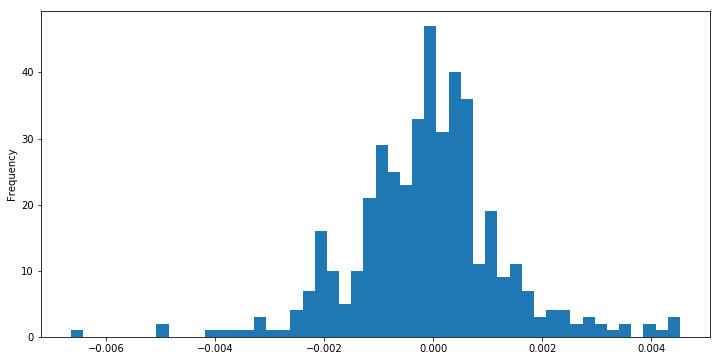

In [39]:
(np.log(data.sma2/data.close)).plot(kind='hist', bins=50, figsize=(12,6))

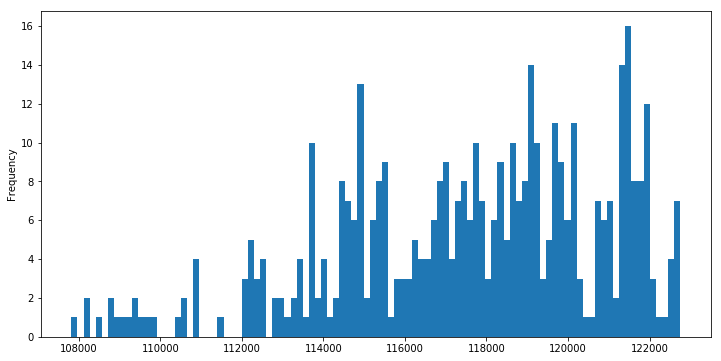

In [38]:
# data.vol.plot(kind='hist', bins=50, figsize=(12,6))
data.sma2.plot(kind='hist', bins=100, figsize=(12,6))

In [ ]:
# (np.log(data.sma16/data.close)).plot(kind='hist', bins=50, figsize=(12,6))

In [16]:
def calculate_input(dat):
    input_vec = np.zeros(4)
#     input_vec[0] = np.log(data['sma2'][0] / data['close'][0])
#     input_vec[1] = np.log(data['sma4'][0] / data['close'][0])
#     input_vec[2] = np.log(data['sma8'][0] / data['close'][0])
#     input_vec[3] = np.log(data['sma16'][0] / data['close'][0])
#     return 1e2*np.array([input_vec])
    input_vec[0] = dat['sma2'][0]
    input_vec[1] = dat['sma4'][0]
    input_vec[2] = dat['sma8'][0]
    input_vec[3] = dat['sma16'][0]
    return np.array([input_vec])

In [17]:
def calculate_output(data):
    if data['close'][lookforward - 1] > data['open'][0]:
        return 1
    else:
        return 0

In [20]:
lookback = 16
lookforward = 3
data = loader.import_data(
        ticker,
        timeframe,
        start_date,
        end_date,
        calculate_input,
        lookback,
        calculate_output,
        lookforward,
        split=(80, 20),
        indicators=inds)

In [21]:
data['train_input'].shape

(1089, 4)

In [34]:
data

{'test_input': array([[119385.   , 119340.   , 119591.25 , 119848.75 ],
        [119445.   , 119422.5  , 119511.25 , 119813.125],
        [119660.   , 119522.5  , 119452.5  , 119798.125],
        ...,
        [118255.   , 118150.   , 118183.75 , 118028.75 ],
        [118270.   , 118217.5  , 118190.   , 118055.625],
        [118305.   , 118280.   , 118193.75 , 118088.75 ]]),
 'test_output': array([[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
      

In [47]:
model.save('red_circule__.h5')